In [1]:
import uproot	
import numpy as np
import sys
import os
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import itertools
import awkward as ak
from scipy.optimize import curve_fit
from mpl_toolkits.axes_grid1 import ImageGrid
%matplotlib inline

In [2]:
file = uproot.open("tracking_losses_ntuple_Bd2KstEE.root:PrDebugTrackingLosses.PrDebugTrackingTool/Tuple;1")

#selektiere nur elektronen von B->K*ee und nur solche mit einem momentum von ueber 5 GeV 
allcolumns = file.arrays()
found = allcolumns[(allcolumns.isElectron) & (~allcolumns.lost) & (allcolumns.fromSignal) & (allcolumns.p > 5e3)] #B: 9056
lost = allcolumns[(allcolumns.isElectron) & (allcolumns.lost) & (allcolumns.fromSignal) & (allcolumns.p > 5e3)] #B: 1466

ak.num(found, axis=0) + ak.num(lost, axis=0)
#ak.count(found, axis=None)

10522

In [3]:
def t_eff(found, lost, axis = 0):
    sel = ak.num(found, axis=axis)
    des = ak.num(lost, axis=axis)
    return sel/(sel + des)

def eff_err(found, lost):
    n_f = ak.num(found, axis=0)
    n_all = ak.num(found, axis=0) + ak.num(lost,axis=0)
    return 1/n_all * np.sqrt(np.abs(n_f*(1-n_f/n_all)))


print("eff all = ", t_eff(found, lost), "+/-", eff_err(found, lost))

eff all =  0.8606728758791105 +/- 0.003375885792719708


In [4]:
#try excluding all photons that originate from a vtx @ z>9500mm
#ignore all brem vertices @ z>9500mm 

#found

brem_e_f = found["brem_photons_pe"]
brem_z_f = found["brem_vtx_z"]
e_f = found["energy"]
length_f = found["brem_vtx_z_length"]

brem_f = ak.ArrayBuilder()

for itr in range(ak.num(found,axis=0)):
    brem_f.begin_record()
    #[:,"energy"] energy
    brem_f.field("energy").append(e_f[itr])
    #[:,"photon_length"] number of vertices
    brem_f.field("photon_length").integer(length_f[itr])
    #[:,"brem_photons_pe",:] photon energy 
    brem_f.field("brem_photons_pe").append(brem_e_f[itr])
    #[:,"brem_vtx_z",:] brem vtx z
    brem_f.field("brem_vtx_z").append(brem_z_f[itr])
    brem_f.end_record()

brem_f = ak.Array(brem_f)

#lost

brem_e_l = lost["brem_photons_pe"]
brem_z_l = lost["brem_vtx_z"]
e_l = lost["energy"]
length_l = lost["brem_vtx_z_length"]

brem_l = ak.ArrayBuilder()

for itr in range(ak.num(lost,axis=0)):
    brem_l.begin_record()
    #[:,"energy"] energy
    brem_l.field("energy").append(e_l[itr])
    #[:,"photon_length"] number of vertices
    brem_l.field("photon_length").integer(length_l[itr])
    #[:,"brem_photons_pe",:] photon energy 
    brem_l.field("brem_photons_pe").append(brem_e_l[itr])
    #[:,"brem_vtx_z",:] brem vtx z
    brem_l.field("brem_vtx_z").append(brem_z_l[itr])
    brem_l.end_record()

brem_l = ak.Array(brem_l)

In [5]:
cut_brem_found = ak.ArrayBuilder()

for itr in range(ak.num(brem_f, axis=0)):
    cut_brem_found.begin_record()
    cut_brem_found.field("energy").real(brem_f[itr,"energy"])
    
    cut_brem_found.field("brem_photons_pe")
    cut_brem_found.begin_list()
    for jentry in range(brem_f[itr, "photon_length"]):
        if brem_f[itr, "brem_vtx_z", jentry]>9500:
            continue
        else:
            cut_brem_found.real(brem_f[itr,"brem_photons_pe", jentry])
            
            #cut_brem_found.field("brem_vtx_z").real(brem_f[itr, "brem_vtx_z",jentry])
    cut_brem_found.end_list()
    
    cut_brem_found.field("brem_vtx_z")
    cut_brem_found.begin_list()
    for jentry in range(brem_f[itr, "photon_length"]):
        if brem_f[itr, "brem_vtx_z", jentry]>9500:
            continue
        else:
            cut_brem_found.real(brem_f[itr, "brem_vtx_z",jentry])
    cut_brem_found.end_list()
    

    
    cut_brem_found.end_record()

cut_brem_found = ak.Array(cut_brem_found)



cut_brem_lost = ak.ArrayBuilder()

for itr in range(ak.num(brem_l, axis=0)):
    cut_brem_lost.begin_record()
    cut_brem_lost.field("energy").real(brem_l[itr,"energy"])
    
    
    cut_brem_lost.field("brem_photons_pe")
    cut_brem_lost.begin_list()
    for jentry in range(brem_l[itr, "photon_length"]):
        if brem_l[itr, "brem_vtx_z", jentry]>9500:
            continue
        else:
            cut_brem_lost.real(brem_l[itr,"brem_photons_pe", jentry])
            
            #cut_brem_found.field("brem_vtx_z").real(brem_f[itr, "brem_vtx_z",jentry])
    cut_brem_lost.end_list()
    
    cut_brem_lost.field("brem_vtx_z")
    cut_brem_lost.begin_list()
    for jentry in range(brem_l[itr, "photon_length"]):
        if brem_l[itr, "brem_vtx_z", jentry]>9500:
            continue
        else:
            cut_brem_lost.real(brem_l[itr, "brem_vtx_z",jentry])
    cut_brem_lost.end_list()
        
    cut_brem_lost.end_record()

cut_brem_lost = ak.Array(cut_brem_lost)


In [6]:
#data in cut_brem_found and cut_brem_lost

cut_length_found = ak.num(cut_brem_found["brem_photons_pe"],axis=-1)
cut_length_lost = ak.num(cut_brem_lost["brem_photons_pe"], axis=-1)

cut_brem_found[1]


<Record {energy: 9.36e+03, ...} type='{energy: float64, brem_photons_pe: va...'>

In [7]:
cut_length_found[1]

8

### Split in Upstream and Downstream Events and analyse separately

In [8]:
#try to find a split between energy lost before and after the magnet (z~5000mm)

upstream_found = ak.ArrayBuilder()
downstream_found = ak.ArrayBuilder()

for itr in range(ak.num(cut_brem_found, axis=0)):
    upstream_found.begin_record()
    upstream_found.field("energy").real(cut_brem_found[itr,"energy"])
    
    downstream_found.begin_record()
    downstream_found.field("energy").real(cut_brem_found[itr,"energy"])
    
    upstream_found.field("brem_photons_pe")
    downstream_found.field("brem_photons_pe")
    upstream_found.begin_list()
    downstream_found.begin_list()
    for jentry in range(cut_length_found[itr]):
        if (cut_brem_found[itr, "brem_vtx_z", jentry]>5000):
            if cut_brem_found[itr, "brem_vtx_z", jentry]<=9500:
                downstream_found.real(cut_brem_found[itr,"brem_photons_pe",jentry])
            else:
                continue
        else:
            upstream_found.real(cut_brem_found[itr,"brem_photons_pe", jentry])            
    upstream_found.end_list()
    downstream_found.end_list()
    
    upstream_found.field("brem_vtx_z")
    downstream_found.field("brem_vtx_z")
    upstream_found.begin_list()
    downstream_found.begin_list()
    for jentry in range(cut_length_found[itr]):
        if cut_brem_found[itr, "brem_vtx_z", jentry]>5000:
            if cut_brem_found[itr,"brem_vtx_z",jentry]<=9500:
                downstream_found.real(cut_brem_found[itr,"brem_vtx_z",jentry])
            else:
                continue
        else:
            upstream_found.real(cut_brem_found[itr, "brem_vtx_z",jentry])
    upstream_found.end_list()
    downstream_found.end_list()
    upstream_found.end_record()
    downstream_found.end_record()
    

upstream_found = ak.Array(upstream_found)
downstream_found = ak.Array(downstream_found)


upstream_lost = ak.ArrayBuilder()
downstream_lost = ak.ArrayBuilder()

for itr in range(ak.num(cut_brem_lost, axis=0)):
    upstream_lost.begin_record()
    upstream_lost.field("energy").real(cut_brem_lost[itr,"energy"])
    
    downstream_lost.begin_record()
    downstream_lost.field("energy").real(cut_brem_lost[itr,"energy"])
    
    upstream_lost.field("brem_photons_pe")
    downstream_lost.field("brem_photons_pe")
    upstream_lost.begin_list()
    downstream_lost.begin_list()
    for jentry in range(cut_length_lost[itr]):
        if (cut_brem_lost[itr, "brem_vtx_z", jentry]>5000):
            if cut_brem_lost[itr, "brem_vtx_z", jentry]<=9500:
                downstream_lost.real(cut_brem_lost[itr,"brem_photons_pe",jentry])
            else:
                continue
        else:
            upstream_lost.real(cut_brem_lost[itr,"brem_photons_pe", jentry])            
    upstream_lost.end_list()
    downstream_lost.end_list()
    
    upstream_lost.field("brem_vtx_z")
    downstream_lost.field("brem_vtx_z")
    upstream_lost.begin_list()
    downstream_lost.begin_list()
    for jentry in range(cut_length_lost[itr]):
        if cut_brem_lost[itr, "brem_vtx_z", jentry]>5000:
            if cut_brem_lost[itr,"brem_vtx_z",jentry]<=9500:
                downstream_lost.real(cut_brem_lost[itr,"brem_vtx_z",jentry])
            else:
                continue
        else:
            upstream_lost.real(cut_brem_lost[itr, "brem_vtx_z",jentry])
    upstream_lost.end_list()
    downstream_lost.end_list()
    upstream_lost.end_record()
    downstream_lost.end_record()
    

upstream_lost = ak.Array(upstream_lost)
downstream_lost = ak.Array(downstream_lost)


In [9]:
upstream_found[0]

<Record {energy: 4.62e+04, ...} type='{energy: float64, brem_photons_pe: va...'>

In [13]:
#plot efficiency against cutoff energy 
up_efficiencies = []
up_deff = []


for cutoff_energy in range(0,10050,200):
	up_nobrem_f = upstream_found[ak.sum(upstream_found["brem_photons_pe"],axis=-1,keepdims=False)<cutoff_energy]
	up_nobrem_l = upstream_lost[ak.sum(upstream_lost["brem_photons_pe"],axis=-1,keepdims=False)<cutoff_energy]
	
	if ak.num(up_nobrem_f,axis=0)+ak.num(up_nobrem_l,axis=0)==0:
		up_efficiencies.append(0)
		up_deff.append(0)
		continue

	eff = t_eff(up_nobrem_f,up_nobrem_l)
	deff = eff_err(up_nobrem_f,up_nobrem_l)
	up_efficiencies.append(eff)
	up_deff.append(deff)

	#print("\ncutoff = ",str(cutoff_energy),"MeV, sample size: ",ak.num(up_nobrem_f,axis=0)+ak.num(up_nobrem_l,axis=0))
	#print("eff = ",np.round(eff,4), "+/-", np.round(eff_err(up_nobrem_f, up_nobrem_l),4))

"""
we see that a cutoff energy of xxxMeV is ideal because the efficiency drops significantly for higher values
"""
cutoff_energy = 350.0 #MeV

"""
better statistics: cutoff=xxxMeV - sample size: xxx events and efficiency=xxxx
"""
up_nobrem_found = upstream_found[ak.sum(upstream_found["brem_photons_pe"],axis=-1,keepdims=False)<cutoff_energy]
up_nobrem_lost = upstream_lost[ak.sum(upstream_lost["brem_photons_pe"],axis=-1,keepdims=False)<cutoff_energy]

print("\nupstream: cutoff energy = 350MeV, sample size:",ak.num(up_nobrem_found,axis=0)+ak.num(up_nobrem_lost,axis=0))
print("eff = ",np.round(t_eff(up_nobrem_found, up_nobrem_lost),4), "+/-", np.round(eff_err(up_nobrem_found, up_nobrem_lost),3))



upstream: cutoff energy = 350MeV, sample size: 1562
eff =  0.9181 +/- 0.007


In [14]:
down_efficiencies = []
down_deff = []

for cutoff_energy in range(0,10050,200):
	down_nobrem_f = downstream_found[ak.sum(downstream_found["brem_photons_pe"],axis=-1,keepdims=False)<cutoff_energy]
	down_nobrem_l = downstream_lost[ak.sum(downstream_lost["brem_photons_pe"],axis=-1,keepdims=False)<cutoff_energy]

	if ak.num(down_nobrem_f,axis=0)+ak.num(down_nobrem_l,axis=0)==0:
		down_efficiencies.append(0)
		down_deff.append(0)
		continue
	eff = t_eff(down_nobrem_f,down_nobrem_l)
	deff = eff_err(down_nobrem_f,down_nobrem_l)
	down_efficiencies.append(eff)
	down_deff.append(deff)


	#print("\ncutoff = ",str(cutoff_energy),"MeV, sample size: ",ak.num(down_nobrem_f,axis=0)+ak.num(down_nobrem_l,axis=0))
	#print("eff = ",np.round(eff,4), "+/-", np.round(eff_err(down_nobrem_f, down_nobrem_l),4))

"""
we see that a cutoff energy of xxxMeV is ideal because the efficiency drops significantly for higher values
"""
cutoff_energy = 350.0 #MeV

"""
better statistics: cutoff=xxxMeV - sample size: xxx events and efficiency=xxxx
"""
down_nobrem_found = downstream_found[ak.sum(downstream_found["brem_photons_pe"],axis=-1,keepdims=False)<cutoff_energy]
down_nobrem_lost = downstream_lost[ak.sum(downstream_lost["brem_photons_pe"],axis=-1,keepdims=False)<cutoff_energy]


print("nobrem_vertices\nupstream: cutoff energy = 350MeV, sample size:",ak.num(up_nobrem_found,axis=0)+ak.num(up_nobrem_lost,axis=0))
print("eff = ",np.round(t_eff(up_nobrem_found, up_nobrem_lost),4), "+/-", np.round(eff_err(up_nobrem_found, up_nobrem_lost),3))

print("\ndownstream: cutoff energy = 350MeV, sample size:",ak.num(down_nobrem_found,axis=0)+ak.num(down_nobrem_lost,axis=0))
print("eff = ",np.round(t_eff(down_nobrem_found, down_nobrem_lost),4), "+/-", np.round(eff_err(down_nobrem_found, down_nobrem_lost),3))


nobrem_vertices
upstream: cutoff energy = 350MeV, sample size: 1562
eff =  0.9181 +/- 0.007

downstream: cutoff energy = 350MeV, sample size: 5131
eff =  0.8864 +/- 0.004


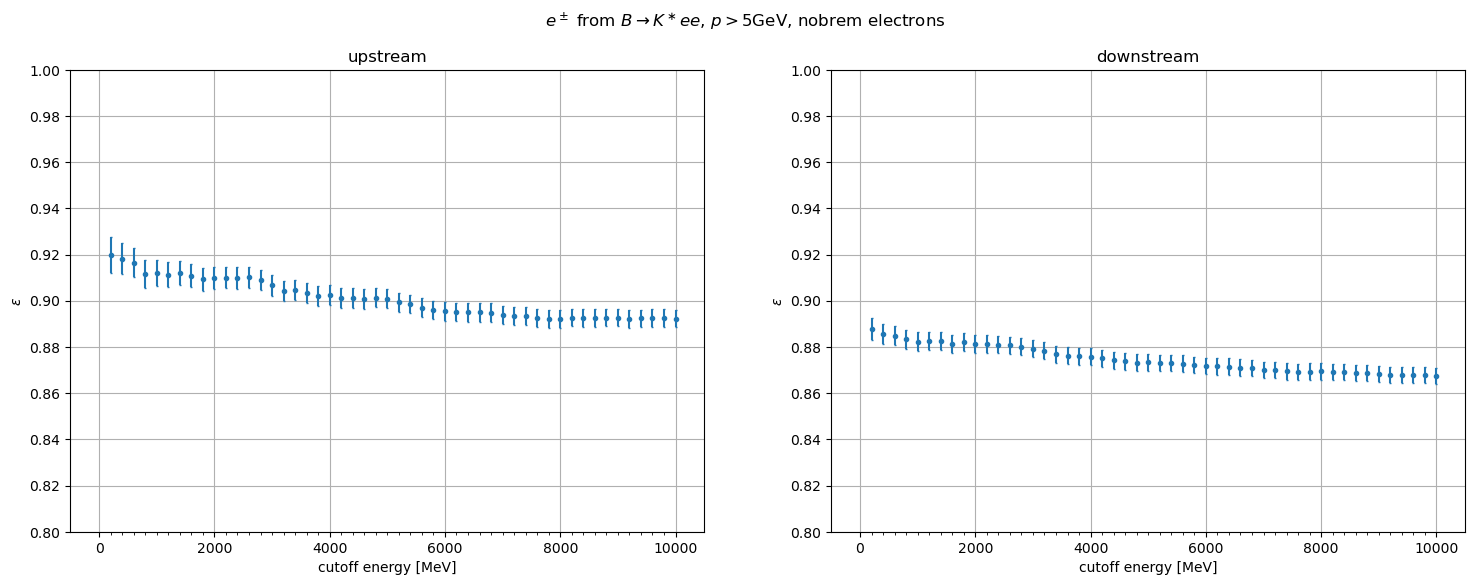

In [17]:
#plot efficiencies wrt cutoff energy
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(18,6))
x_ = np.arange(0,10050,step=200)

ax[0].errorbar(x_,up_efficiencies,yerr=up_deff, ls="", capsize=1,fmt=".")
ax[0].set(xlabel="cutoff energy [MeV]",ylabel=r"$\epsilon$",title="upstream", ylim=[0.8,1.0])
ax[0].set_yticks(np.arange(0.8,1.01,step=0.02),minor=False)
ax[0].set_xticks(np.arange(0,10100,step=200),minor=True)
ax[0].grid()

ax[1].errorbar(x_,down_efficiencies,yerr=down_deff, ls="", capsize=1,fmt=".")
ax[1].set(xlabel="cutoff energy [MeV]",ylabel=r"$\epsilon$",title="downstream", ylim=[0.8,1.0])
ax[1].set_yticks(np.arange(0.8,1.01,step=0.02),minor=False)
ax[1].set_xticks(np.arange(0,10100,step=200),minor=True)
ax[1].grid(True)

fig.suptitle(r"$e^\pm$ from $B\rightarrow K^\ast ee$, $p>5$GeV, nobrem electrons")


plt.show()

In [13]:
cutoff_energy=350
#possibly: instead of checking if any photons exceed the cutoff, use the sum of all photon energies to separate nobrem and brem

upstream_brem_found = upstream_found[ak.sum(upstream_found["brem_photons_pe"],axis=-1,keepdims=False)>=cutoff_energy]
up_energy_found = ak.to_numpy(upstream_brem_found["energy"])
up_eph_found = ak.to_numpy(ak.sum(upstream_brem_found["brem_photons_pe"], axis=-1, keepdims=False))
up_residual_found = up_energy_found - up_eph_found
up_energyloss_found = up_eph_found/up_energy_found


upstream_brem_lost = upstream_lost[ak.sum(upstream_lost["brem_photons_pe"],axis=-1,keepdims=False)>=cutoff_energy]
up_energy_lost = ak.to_numpy(upstream_brem_lost["energy"])
up_eph_lost = ak.to_numpy(ak.sum(upstream_brem_lost["brem_photons_pe"], axis=-1, keepdims=False))
up_residual_lost = up_energy_lost - up_eph_lost
up_energyloss_lost = up_eph_lost/up_energy_lost


print("brem vertices\nupstream eff = ", np.round(t_eff(upstream_brem_found,upstream_brem_lost),3), "+/-", np.round(eff_err(upstream_brem_found, upstream_brem_lost),3))


downstream_brem_found = downstream_found[ak.sum(downstream_found["brem_photons_pe"],axis=-1,keepdims=False)>=cutoff_energy]
down_energy_found = ak.to_numpy(downstream_brem_found["energy"])
down_eph_found = ak.to_numpy(ak.sum(downstream_brem_found["brem_photons_pe"], axis=-1, keepdims=False))
down_residual_found = down_energy_found - down_eph_found
down_energyloss_found = down_eph_found/down_energy_found


downstream_brem_lost = downstream_lost[ak.sum(downstream_lost["brem_photons_pe"],axis=-1,keepdims=False)>=cutoff_energy]
down_energy_lost = ak.to_numpy(downstream_brem_lost["energy"])
down_eph_lost = ak.to_numpy(ak.sum(downstream_brem_lost["brem_photons_pe"], axis=-1, keepdims=False))
down_residual_lost = down_energy_lost - down_eph_lost
down_energyloss_lost = down_eph_lost/down_energy_lost


print("downstream eff = ", np.round(t_eff(downstream_brem_found,downstream_brem_lost),3), "+/-", np.round(eff_err(downstream_brem_found, downstream_brem_lost),3))

brem vertices
upstream eff =  0.851 +/- 0.004
downstream eff =  0.836 +/- 0.005


In [14]:
print("upstream:\nmean energyloss relative to initial energy (found): ",ak.mean(up_energyloss_found))
print("mean energyloss relative to initial energy (lost): ", ak.mean(up_energyloss_lost))

print("downstream:\nmean energyloss relative to initial energy (found): ",ak.mean(down_energyloss_found))
print("mean energyloss relative to initial energy (lost): ", ak.mean(down_energyloss_lost))

upstream:
mean energyloss relative to initial energy (found):  0.33078325542598164
mean energyloss relative to initial energy (lost):  0.5708618852236069
downstream:
mean energyloss relative to initial energy (found):  0.19104090843883118
mean energyloss relative to initial energy (lost):  0.3051594568487781


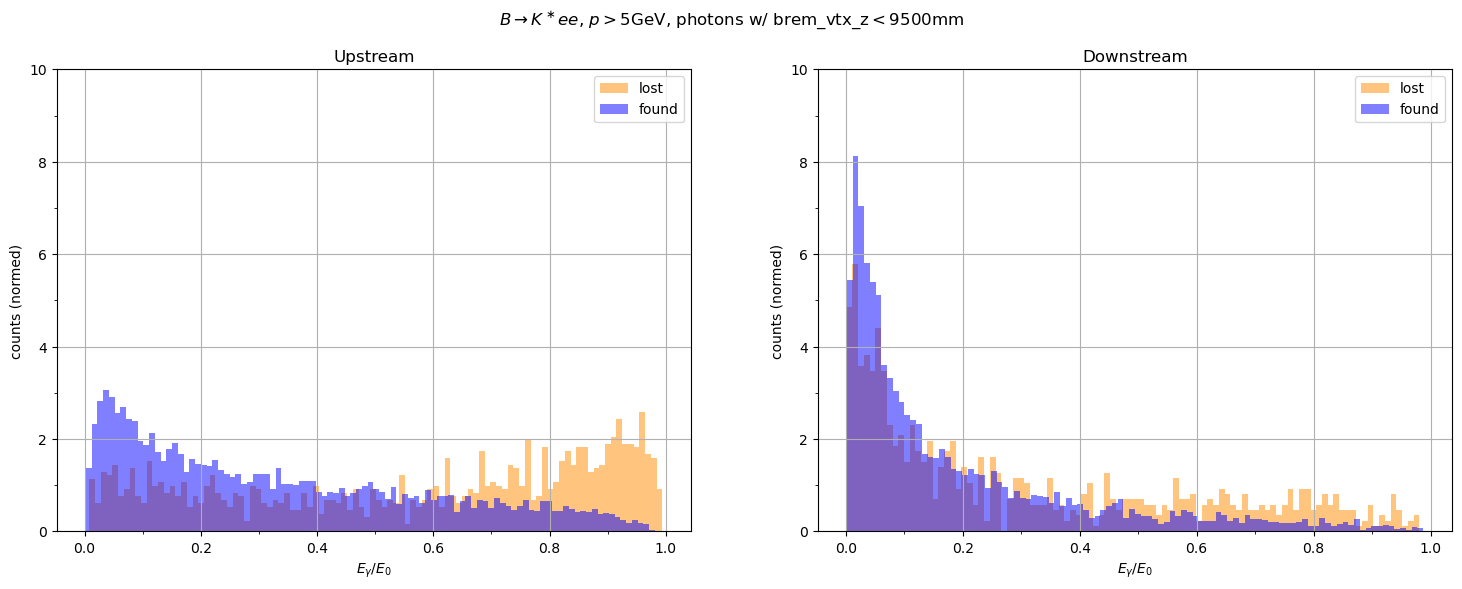

In [15]:
#in abhängigkeit von der energie der elektronen
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,6))


ax[0].hist(up_energyloss_lost, bins=100, density=True, alpha=0.5, histtype='bar', color="darkorange", label="lost")
ax[0].hist(up_energyloss_found, bins=100, density=True, alpha=0.5, histtype='bar', color="blue", label="found")
ax[0].set_xticks(np.arange(0,1.1,0.1), minor=True,)
ax[0].set_yticks(np.arange(0,11,1), minor=True)
ax[0].set_xlabel(r"$E_\gamma/E_0$")
ax[0].set_ylabel("counts (normed)")
ax[0].set_title("Upstream")
ax[0].legend()
ax[0].grid()

ax[1].hist(down_energyloss_lost, bins=100, density=True, alpha=0.5, histtype='bar', color="darkorange", label="lost")
ax[1].hist(down_energyloss_found, bins=100, density=True, alpha=0.5, histtype='bar', color="blue", label="found")
ax[1].set_xticks(np.arange(0,1.1,0.1), minor=True,)
ax[1].set_yticks(np.arange(0,11,1), minor=True)
ax[1].set_xlabel(r"$E_\gamma/E_0$")
ax[1].set_ylabel("counts (normed)")
ax[1].set_title("Downstream")
ax[1].legend()
ax[1].grid()

"""
most electrons lose little energy relative to their initial energy downstream
"""
fig.suptitle(r"$B\rightarrow K^\ast ee$, $p>5$GeV, photons w/ brem_vtx_z$<9500$mm")
plt.show()

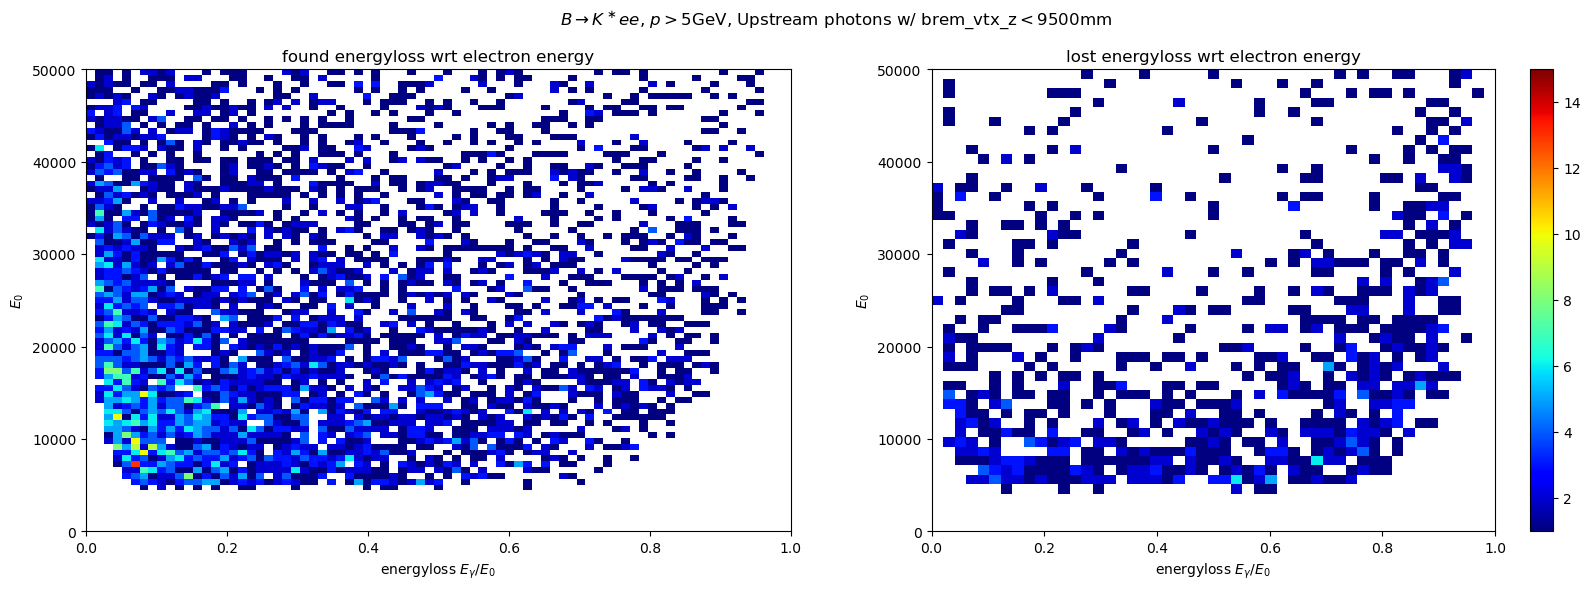

In [20]:
#energyloss in abh von der energie der elektronen
#upstream
fig, ((ax0, ax1)) = plt.subplots(nrows=1, ncols=2, figsize=(20,6))

a0=ax0.hist2d(up_energyloss_found, up_energy_found, bins=(np.linspace(0,1,80), np.linspace(0,5e4,80)), cmap=plt.cm.jet, cmin=1, vmax=15)
ax0.set_ylim(0,5e4)
ax0.set_xlim(0,1)
ax0.set_xlabel(r"energyloss $E_\gamma/E_0$")
ax0.set_ylabel(r"$E_0$")
ax0.set_title("found energyloss wrt electron energy")

a1=ax1.hist2d(up_energyloss_lost, up_energy_lost, bins=(np.linspace(0,1,50), np.linspace(0,5e4,50)), cmap=plt.cm.jet, cmin=1, vmax=15)
ax1.set_ylim(0,5e4)
ax1.set_xlim(0,1)
ax1.set_xlabel(r"energyloss $E_\gamma/E_0$")
ax1.set_ylabel(r"$E_0$")
ax1.set_title("lost energyloss wrt electron energy")

fig.colorbar(a1[3],ax=ax1)
fig.suptitle(r"$B\rightarrow K^\ast ee$, $p>5$GeV, Upstream photons w/ brem_vtx_z$<9500$mm")


plt.show()

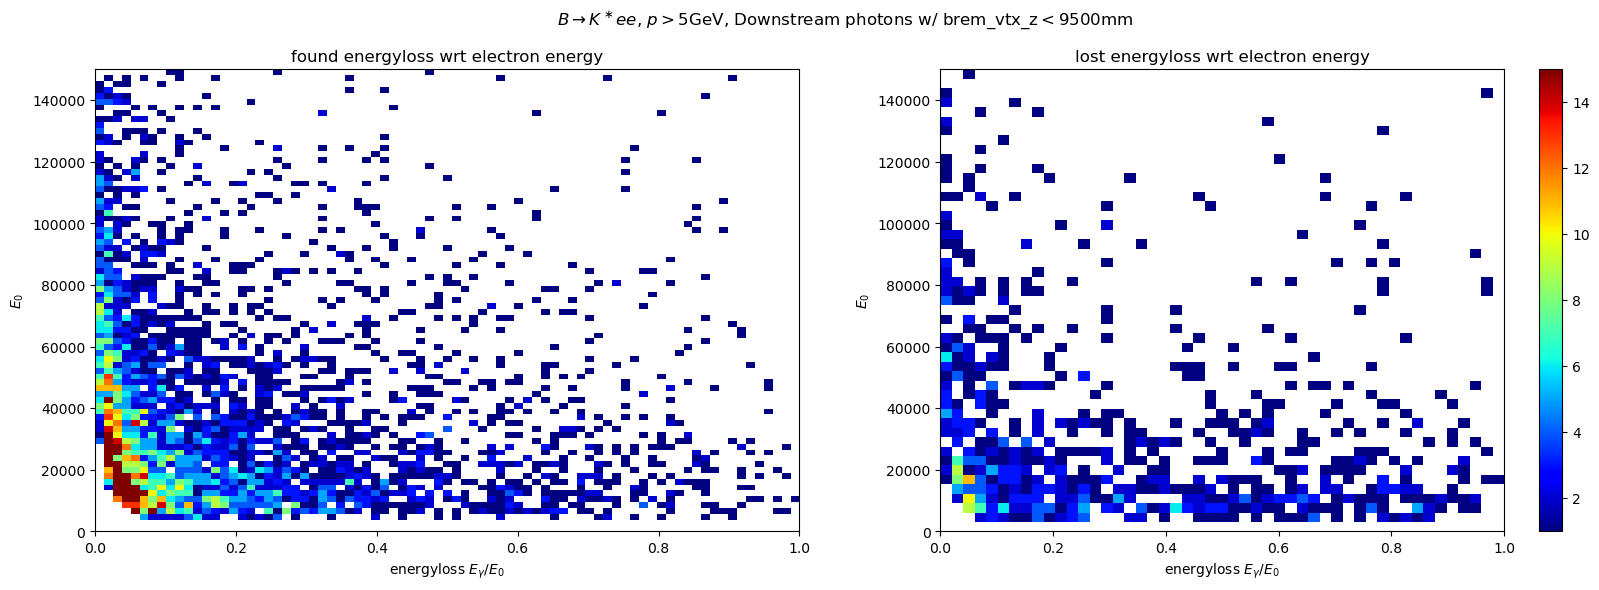

In [17]:
#downstream
fig, ((ax0, ax1)) = plt.subplots(nrows=1, ncols=2, figsize=(20,6))

a0=ax0.hist2d(down_energyloss_found, down_energy_found, bins=(np.linspace(0,1,80), np.linspace(0,5e4,80)), cmap=plt.cm.jet, cmin=1, vmax=15)
ax0.set_ylim(0,5e4)
ax0.set_xlim(0,1)
ax0.set_xlabel(r"energyloss $E_\gamma/E_0$")
ax0.set_ylabel(r"$E_0$")
ax0.set_title("found energyloss wrt electron energy")

a1=ax1.hist2d(down_energyloss_lost, down_energy_lost, bins=(np.linspace(0,1,50), np.linspace(0,5e4,50)), cmap=plt.cm.jet, cmin=1, vmax=15)
ax1.set_ylim(0,5e4)
ax1.set_xlim(0,1)
ax1.set_xlabel(r"energyloss $E_\gamma/E_0$")
ax1.set_ylabel(r"$E_0$")
ax1.set_title("lost energyloss wrt electron energy")

fig.colorbar(a1[3],ax=ax1)
fig.suptitle(r"$B\rightarrow K^\ast ee$, $p>5$GeV, Downstream photons w/ brem_vtx_z$<9500$mm")


plt.show()

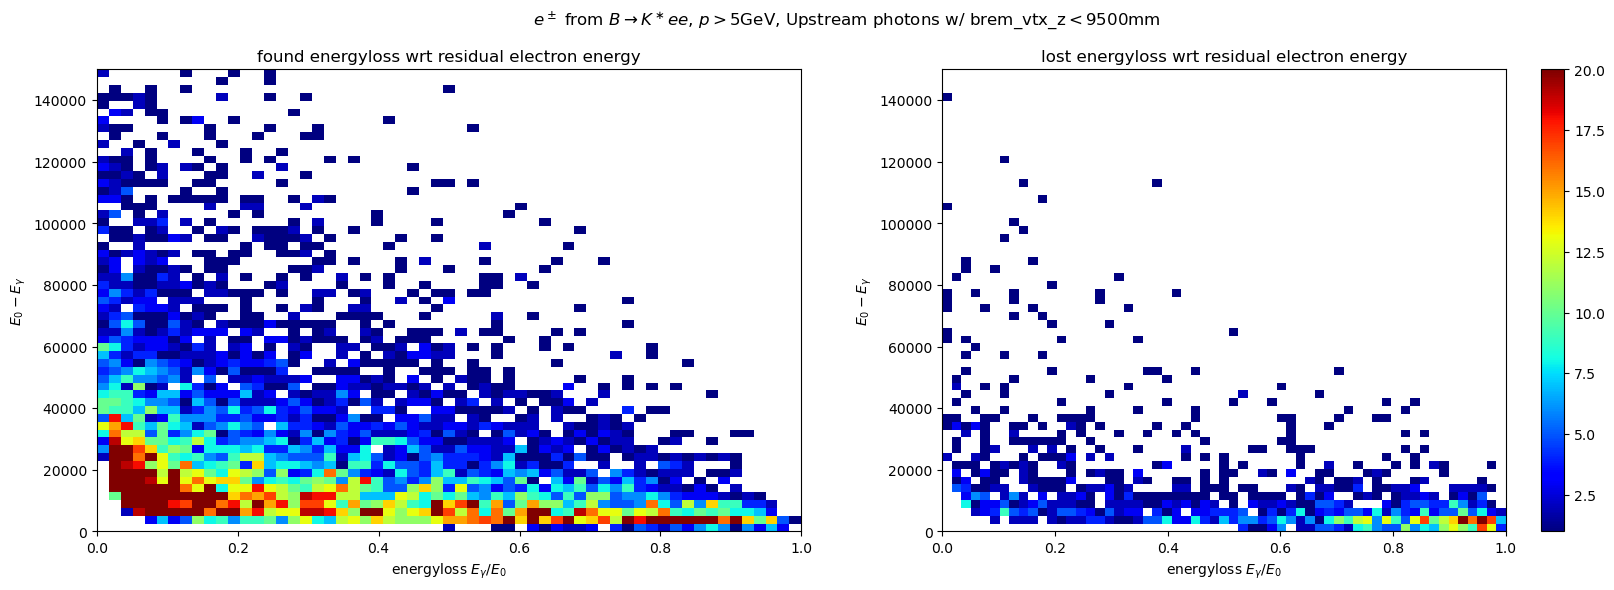

In [18]:
#plot residual energy against energyloss and try to find a good split (eg energyloss before and after the magnet)
#upstream
nbins=60

fig, ((ax0, ax1)) = plt.subplots(nrows=1, ncols=2, figsize=(20,6))

a0=ax0.hist2d(up_energyloss_found, up_residual_found, bins=(np.linspace(0,1,nbins), np.linspace(0,5e4,nbins)), cmap=plt.cm.jet, cmin=1, vmax=20)
ax0.set_ylim(0,5e4)
ax0.set_xlim(0,1)
ax0.set_xlabel(r"energyloss $E_\gamma/E_0$")
ax0.set_ylabel(r"$E_0-E_\gamma$")
ax0.set_title("found energyloss wrt residual electron energy")

a1=ax1.hist2d(up_energyloss_lost, up_residual_lost, bins=(np.linspace(0,1,nbins), np.linspace(0,5e4,nbins)), cmap=plt.cm.jet, cmin=1, vmax=20) 
ax1.set_ylim(0,5e4)
ax1.set_xlim(0,1)
ax1.set_xlabel(r"energyloss $E_\gamma/E_0$")
ax1.set_ylabel(r"$E_0-E_\gamma$")
ax1.set_title("lost energyloss wrt residual electron energy")

fig.colorbar(a1[3],ax=ax1)
fig.suptitle(r"$e^\pm$ from $B\rightarrow K^\ast ee$, $p>5$GeV, Upstream photons w/ brem_vtx_z$<9500$mm")

"""
"""
plt.show()

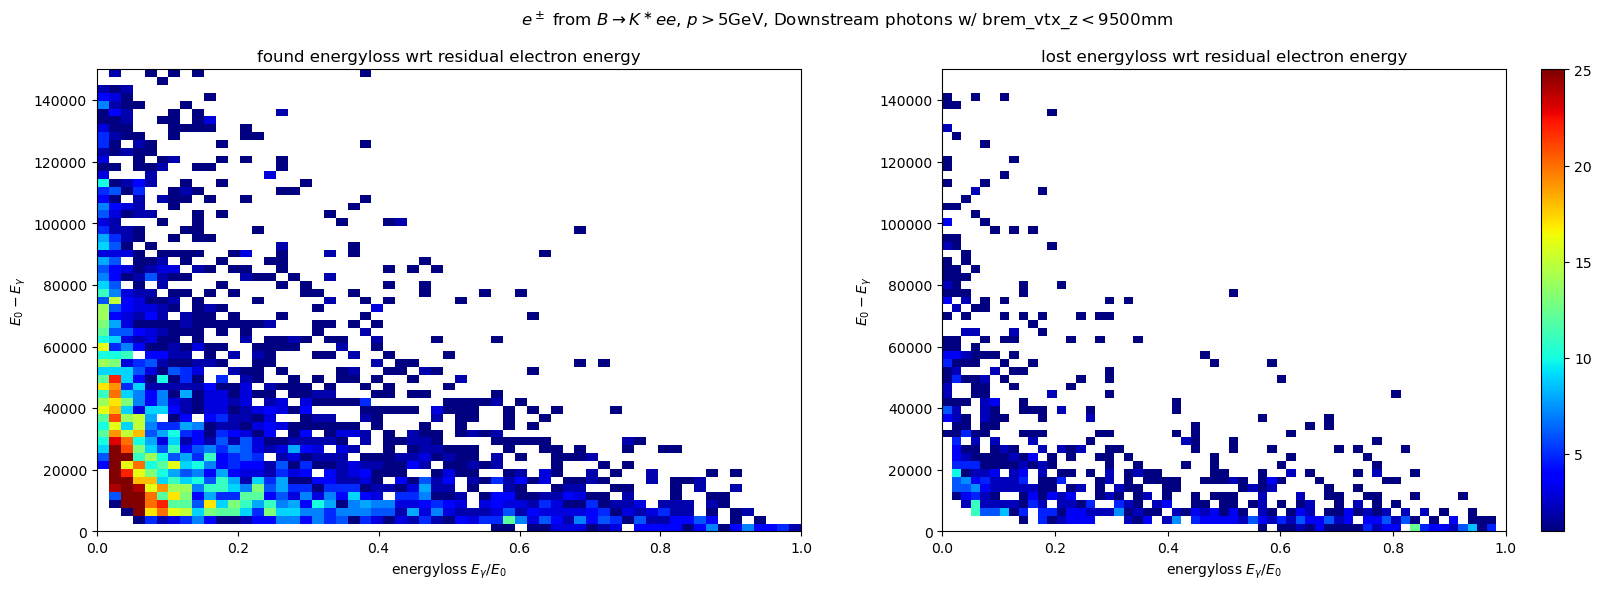

In [19]:
#downstream
fig, ((ax0, ax1)) = plt.subplots(nrows=1, ncols=2, figsize=(20,6))

a0=ax0.hist2d(down_energyloss_found, down_residual_found, bins=(np.linspace(0,1,60), np.linspace(0,5e4,60)), cmap=plt.cm.jet, cmin=1, vmax=25)
ax0.set_ylim(0,5e4)
ax0.set_xlim(0,1)
ax0.set_xlabel(r"energyloss $E_\gamma/E_0$")
ax0.set_ylabel(r"$E_0-E_\gamma$")
ax0.set_title("found energyloss wrt residual electron energy")

a1=ax1.hist2d(down_energyloss_lost, down_residual_lost, bins=(np.linspace(0,1,60), np.linspace(0,5e4,60)), cmap=plt.cm.jet, cmin=1, vmax=20) 
ax1.set_ylim(0,5e4)
ax1.set_xlim(0,1)
ax1.set_xlabel(r"energyloss $E_\gamma/E_0$")
ax1.set_ylabel(r"$E_0-E_\gamma$")
ax1.set_title("lost energyloss wrt residual electron energy")

fig.colorbar(a0[3],ax=ax1)
fig.suptitle(r"$e^\pm$ from $B\rightarrow K^\ast ee$, $p>5$GeV, Downstream photons w/ brem_vtx_z$<9500$mm")

"""
"""
plt.show()